<a href="https://colab.research.google.com/github/rashida048/hypermeter-tuning/blob/main/hyperband_keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
output_path = 'output'

In [3]:
def plot_h(H):
	# plot the training loss and accuracy
	plt.style.use("ggplot")
	plt.figure(figsize = (6, 5))
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend()
	#plt.savefig(path)

In [4]:
def model_build(hp):
  model = Sequential()
  inputShape = (32, 32, 3)
  chanDim = -1 

  model.add(Conv2D(
      hp.Int("conv_1", min_value=64, max_value = 128, 
             step=32), (3, 3), padding='same', input_shape = inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(
      hp.Int("conv_2", min_value=128, max_value = 256, 
             step=32), (3, 3), padding='same', input_shape = inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(hp.Int("dense_units1", min_value=256, max_value = 786, step = 256)))
  model.add(Dense(hp.Int("dense_units2", min_value = 256, max_value = 786, step = 256)))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(10))
  model.add(Activation("softmax"))

  #lr = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])
  #opt = Adam(learning_rate=lr)

  model.compile(loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
  return model

In [5]:
((train_x, train_y), (test_x, test_y)) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [6]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.3 MB/s eta 0:00:00


In [7]:
args  = {
    "tuner": "BayesianOptimization"
}

In [7]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train_y_lb = lb.fit_transform(train_y)
test_y_lb = lb.transform(test_y)

In [8]:
train_y_lb.shape

(50000, 10)

In [10]:
#import keras_tuner as kt
#import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import Hyperband
tuner = Hyperband(
    model_build,
    objective='val_accuracy',
    max_epochs=10)

In [11]:
tuner.search(
    x = train_x, y = train_y,
    validation_data = (test_x, test_y),
    batch_size = 64,
    epochs = 30)

Trial 30 Complete [00h 02m 24s]
val_accuracy: 0.6922000050544739

Best val_accuracy So Far: 0.7228000164031982
Total elapsed time: 00h 26m 19s


In [12]:
hp_best = tuner.get_best_hyperparameters(num_trials=1)[0]

In [13]:
print("conv_1 layer: {}".format(
    hp_best.get("conv_1")
))
print("conv_2 layer: {}".format(
  hp_best.get('conv_2')))
print("dense layer1: {}".format(
  hp_best.get('dense_units1')))
print("dense layer1: {}".format(
  hp_best.get('dense_units2')))
print("learning rate: {}".format(
  hp_best.get('learning_rate')))

conv_1 layer: 96
conv_2 layer: 192
dense layer1: 768
dense layer1: 768
learning rate: 0.001


In [14]:
hp_best

In [17]:
model = tuner.hypermodel.build(hp_best)
opt = Adam(learning_rate=0.001)
H = model.fit(x = train_x, y = train_y,
              validation_data = (test_x, test_y), batch_size = 64,
              epochs = 50, verbose=1)

Epoch 1/50
782/782 [==============================] - 12s 12ms/step - loss: 1.4307 - accuracy: 0.5224 - val_loss: 2.1786 - val_accuracy: 0.4092
Epoch 2/50
782/782 [==============================] - 9s 12ms/step - loss: 0.9423 - accuracy: 0.6728 - val_loss: 1.4268 - val_accuracy: 0.5496
Epoch 3/50
782/782 [==============================] - 10s 13ms/step - loss: 0.7860 - accuracy: 0.7290 - val_loss: 1.0399 - val_accuracy: 0.6531
Epoch 4/50
782/782 [==============================] - 9s 12ms/step - loss: 0.6758 - accuracy: 0.7627 - val_loss: 1.1324 - val_accuracy: 0.6341
Epoch 5/50
782/782 [==============================] - 9s 12ms/step - loss: 0.5863 - accuracy: 0.7985 - val_loss: 1.3240 - val_accuracy: 0.6449
Epoch 6/50
782/782 [==============================] - 10s 13ms/step - loss: 0.5200 - accuracy: 0.8209 - val_loss: 1.3218 - val_accuracy: 0.6321
Epoch 7/50
782/782 [==============================] - 9s 12ms/step - loss: 0.4617 - accuracy: 0.8412 - val_loss: 3.2178 - val_accuracy: 0.4

In [18]:
predictions = model.predict(x=test_x, batch_size=64)

157/157 [==============================] - 1s 3ms/step


In [19]:
print(classification_report(test_y.reshape(10000, ),
	predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      1000
           1       0.91      0.77      0.84      1000
           2       0.58      0.69      0.63      1000
           3       0.52      0.57      0.55      1000
           4       0.68      0.70      0.69      1000
           5       0.64      0.61      0.62      1000
           6       0.77      0.78      0.78      1000
           7       0.76      0.80      0.78      1000
           8       0.84      0.80      0.82      1000
           9       0.81      0.82      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.73     10000
weighted avg       0.73      0.72      0.73     10000



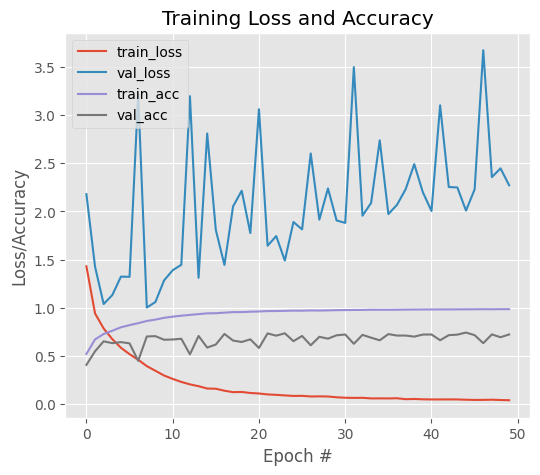

In [20]:
plot_h(H)